In [1]:
import numpy as np
from tqdm import tqdm
import pandas as pd
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from model import GalerkinSARIMA

In [2]:
# Generate toy datasets (for testing)
np.random.seed(123)
n = 300
t = np.arange(n)

# A: Noisy ARMA(2,1)
phi_true = [0.6, -0.3]
theta_true = [0.5]
eps = np.random.normal(scale=1.0, size=n)
y_a = np.zeros(n)
for i in range(2, n):
    y_a[i] = (phi_true[0] * y_a[i-1] + phi_true[1] * y_a[i-2] + theta_true[0] * eps[i-1] + eps[i])

# B: Seasonal sine + noise (period m=20)
y_b = np.sin(2 * np.pi * t / 20) + 0.5 * np.random.normal(size=n)

# C: Linear trend + AR(1)
eps_c = np.random.normal(scale=0.5, size=n)
y_c = np.zeros(n)
for i in range(1, n):
    y_c[i] = 0.01 * i + 0.8 * y_c[i-1] + eps_c[i]

# D: Nonlinear (Logistic map) + noise
r = 3.8
eps_d = np.random.normal(scale=0.02, size=n)
y_d = np.zeros(n)
y_d[0] = 0.4
for i in range(1, n):
    y_d[i] = r * y_d[i-1] * (1 - y_d[i-1]) + eps_d[i]

datasets = {
    'Noisy_ARMA': y_a,
    'Seasonal': y_b,
    'Trend_AR': y_c,
    'Nonlinear': y_d
}


In [3]:


window = 100
horizon = 100
num_runs = 1
p_values = [5]
q_values = [5]
P_values = [5]
Q_values = [5]
m_seasonal = 5

orders = [(p, q, P, Q) for p in p_values for q in q_values for P in P_values for Q in Q_values]


In [15]:
all_results = []
first_run_preds = {}  # Store predictions from first run for plotting

for run in range(1, num_runs + 1):
    runs_left = num_runs - run
    print(f"\n=== Run {run}/{num_runs}  (runs left after this: {runs_left}) ===")

    for name, series in datasets.items():
        m = m_seasonal

        for p, q, P, Q in tqdm(orders, desc=f"Param combos for {name}", total=len(orders), leave=False):
            y_true = series[window:window + horizon]
            preds_g = []

            for i in range(window, window + horizon):
                train = series[:i]
                model = GalerkinSARIMA(
                    train, 
                    order=(p, 0, q), 
                    seasonal_order=(P, 0, Q, m), 
                    basis_functions="quadratic",
                    forecast_method="direct"
                )
                model.fit(train)
                
                # Multi-step forecast
                pred_g = model.forecast(steps=4)
                preds_g.append(pred_g)

            preds_g = np.array(preds_g)
            
            # Extract only the last step of each multi-step forecast
            # If steps=2, we want the second step (index 1)
            last_step_preds = preds_g[:, -1] if preds_g.ndim > 1 else preds_g
            
            if run == 1:
                first_run_preds[(name, p, q, P, Q)] = last_step_preds
            
            mask_g = ~np.isnan(last_step_preds)
            mae_g = mean_absolute_error(y_true[mask_g], last_step_preds[mask_g]) if mask_g.any() else np.nan
            rmse_g = np.sqrt(mean_squared_error(y_true[mask_g], last_step_preds[mask_g])) if mask_g.any() else np.nan

            all_results.append([name, p, q, P, Q, run, 'Galerkin-SARIMA', mae_g, rmse_g])

# Aggregate and print for verification
df = pd.DataFrame(all_results, columns=['Dataset', 'p', 'q', 'P', 'Q', 'Run', 'Alg', 'MAE', 'RMSE'])
agg = df.groupby(['Dataset', 'p', 'q', 'P', 'Q', 'Alg'], as_index=False).mean()

print("\nAveraged over {} runs:\n".format(num_runs))
print(agg.to_markdown(index=False))


=== Run 1/1  (runs left after this: 0) ===



Averaged over 1 runs:

| Dataset    |   p |   q |   P |   Q | Alg             |   Run |       MAE |     RMSE |
|:-----------|----:|----:|----:|----:|:----------------|------:|----------:|---------:|
| Noisy_ARMA |   5 |   5 |   5 |   5 | Galerkin-SARIMA |     1 | 0.838265  | 1.09416  |
| Nonlinear  |   5 |   5 |   5 |   5 | Galerkin-SARIMA |     1 | 0.0170679 | 0.021167 |
| Seasonal   |   5 |   5 |   5 |   5 | Galerkin-SARIMA |     1 | 0.502065  | 0.617097 |
| Trend_AR   |   5 |   5 |   5 |   5 | Galerkin-SARIMA |     1 | 0.500925  | 0.643136 |


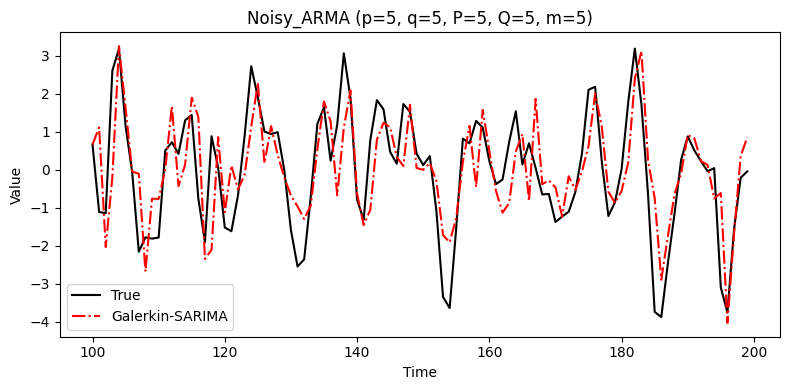

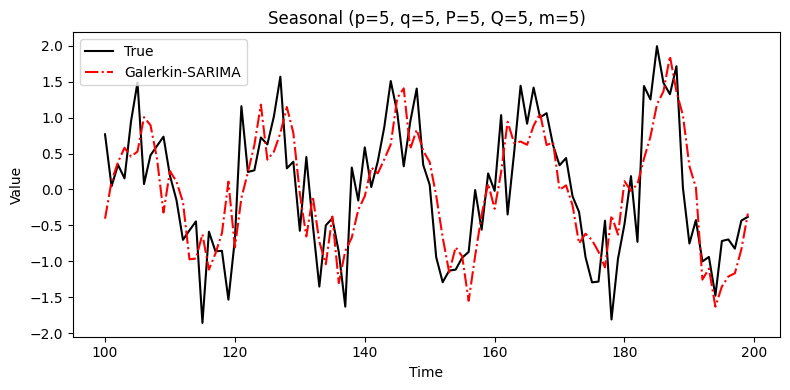

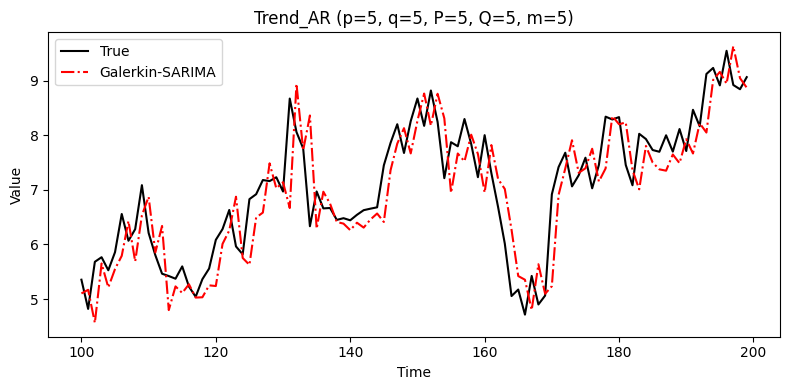

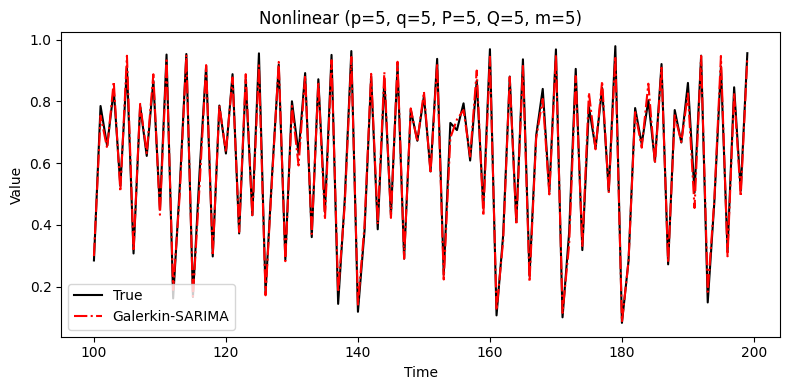

In [16]:

for name, series in datasets.items():
    for p, q, P, Q in orders:
        y_true = series[window:window+horizon]
        sg = first_run_preds[(name,p,q,P,Q)]

        plt.figure(figsize=(8,4))
        plt.plot(range(window,window+horizon), y_true, 'k-', label='True')
        plt.plot(range(window,window+horizon), sg,    'r-.',label='Galerkin-SARIMA')
        plt.title(f"{name} (p={p}, q={q}, P={P}, Q={Q}, m={m})")
        plt.xlabel("Time")
        plt.ylabel("Value")
        plt.legend()
        plt.tight_layout()
        plt.show()